# Feature Selection and Model building 

## Steps

1. First we train test split X and y and scale it.
2. 
We will also do feature selection using a lightgbm model to remove features which are not important
3. 
Then we build different models and see which is the best model using different evaluation
4. .
Afterwards we hyperparameter tune our best model and check our final resu.
5. s.
We also look at the impact of different thresholds.

In [4]:
!pip install lightgbm

In [5]:
!pip install catboost

In [6]:
!pip install metrics

  Using cached Pygments-2.2.0-py2.py3-none-any.whl.metadata (1.5 kB)
Using cached Pygments-2.2.0-py2.py3-none-any.whl (841 kB)
  Attempting uninstall: Pygments
    Found existing installation: Pygments 2.18.0
    Uninstalling Pygments-2.18.0:
      Successfully uninstalled Pygments-2.18.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 8.25.0 requires pygments>=2.4.0, but you have pygments 2.2.0 which is incompatible.
jupyterlab-pygments 0.1.2 requires pygments<3,>=2.4.1, but you have pygments 2.2.0 which is incompatible.
nbconvert 7.10.0 requires pygments>=2.4.1, but you have pygments 2.2.0 which is incompatible.
rich 13.3.5 requires pygments<3.0.0,>=2.13.0, but you have pygments 2.2.0 which is incompatible.
sphinx 7.3.7 requires Pygments>=2.14, but you have pygments 2.2.0 which is incompatible.


In [7]:
!pip install bayesian-optimization

In [8]:
!pip install metrics --use-deprecated=legacy-resolver

In [9]:
!pip uninstall -y pygments
!pip install pygments==2.2.0


Found existing installation: Pygments 2.2.0
Uninstalling Pygments-2.2.0:
  Successfully uninstalled Pygments-2.2.0
  Using cached Pygments-2.2.0-py2.py3-none-any.whl.metadata (1.5 kB)
Using cached Pygments-2.2.0-py2.py3-none-any.whl (841 kB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 8.25.0 requires pygments>=2.4.0, but you have pygments 2.2.0 which is incompatible.
jupyterlab-pygments 0.1.2 requires pygments<3,>=2.4.1, but you have pygments 2.2.0 which is incompatible.
nbconvert 7.10.0 requires pygments>=2.4.1, but you have pygments 2.2.0 which is incompatible.
rich 13.3.5 requires pygments<3.0.0,>=2.13.0, but you have pygments 2.2.0 which is incompatible.
sphinx 7.3.7 requires Pygments>=2.14, but you have pygments 2.2.0 which is incompatible.


In [10]:
!pip install --upgrade xgboost
!pip install --upgrade pygments
!pip install --upgrade jupyter

  Using cached pygments-2.18.0-py3-none-any.whl.metadata (2.5 kB)
Using cached pygments-2.18.0-py3-none-any.whl (1.2 MB)
  Attempting uninstall: pygments
    Found existing installation: Pygments 2.2.0
    Uninstalling Pygments-2.2.0:
      Successfully uninstalled Pygments-2.2.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
metrics 0.3.3 requires Pygments==2.2.0, but you have pygments 2.18.0 which is incompatible.


In [11]:
import sys
from IPython.core import ultratb
sys.excepthook = ultratb.FormattedTB(mode='Plain', color_scheme='NoColor')

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = (10, 6)
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import RocCurveDisplay, roc_auc_score, confusion_matrix, f1_score
from bayes_opt import BayesianOptimization
import gc
pd.set_option('display.max_columns',None) 
import warnings
warnings.filterwarnings('ignore')

In [13]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [14]:
y = pd.read_csv('y.csv')
X = pd.read_csv('X.csv')
X = reduce_mem_usage(X)

Memory usage of dataframe is 1475.69 MB
Memory usage after optimization is: 349.27 MB
Decreased by 76.3%


## Training and Testing Data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Scaling data

In [18]:
X_fe=[feature for feature in X.columns]

In [19]:
cat_fe=['NAME_CONTRACT_TYPE_Cash loans','NAME_CONTRACT_TYPE_Revolving loans','NAME_TYPE_SUITE_Children',
 'NAME_TYPE_SUITE_Family','NAME_TYPE_SUITE_Group of people','NAME_TYPE_SUITE_Other_A','NAME_TYPE_SUITE_Other_B',
 'NAME_TYPE_SUITE_Spouse, partner','NAME_TYPE_SUITE_Unaccompanied','NAME_INCOME_TYPE_Businessman',
 'NAME_INCOME_TYPE_Commercial associate','NAME_INCOME_TYPE_Maternity leave','NAME_INCOME_TYPE_Pensioner',
 'NAME_INCOME_TYPE_State servant','NAME_INCOME_TYPE_Student','NAME_INCOME_TYPE_Unemployed','NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Academic degree','NAME_EDUCATION_TYPE_Higher education','NAME_EDUCATION_TYPE_Incomplete higher',
 'NAME_EDUCATION_TYPE_Lower secondary','NAME_EDUCATION_TYPE_Secondary / secondary special','NAME_FAMILY_STATUS_Civil marriage',
 'NAME_FAMILY_STATUS_Married','NAME_FAMILY_STATUS_Separated','NAME_FAMILY_STATUS_Single / not married',
 'NAME_FAMILY_STATUS_Unknown','NAME_FAMILY_STATUS_Widow','NAME_HOUSING_TYPE_Co-op apartment',
 'NAME_HOUSING_TYPE_House / apartment','NAME_HOUSING_TYPE_Municipal apartment','NAME_HOUSING_TYPE_Office apartment',
 'NAME_HOUSING_TYPE_Rented apartment','NAME_HOUSING_TYPE_With parents','OCCUPATION_TYPE_Accountants',
 'OCCUPATION_TYPE_Cleaning staff','OCCUPATION_TYPE_Cooking staff','OCCUPATION_TYPE_Core staff','OCCUPATION_TYPE_Drivers',
 'OCCUPATION_TYPE_HR staff','OCCUPATION_TYPE_High skill tech staff','OCCUPATION_TYPE_IT staff','OCCUPATION_TYPE_Laborers',
 'OCCUPATION_TYPE_Low-skill Laborers','OCCUPATION_TYPE_Managers','OCCUPATION_TYPE_Medicine staff',
 'OCCUPATION_TYPE_Private service staff','OCCUPATION_TYPE_Realty agents','OCCUPATION_TYPE_Sales staff',
 'OCCUPATION_TYPE_Secretaries','OCCUPATION_TYPE_Security staff','OCCUPATION_TYPE_Waiters/barmen staff',
 'WEEKDAY_APPR_PROCESS_START_FRIDAY','WEEKDAY_APPR_PROCESS_START_MONDAY','WEEKDAY_APPR_PROCESS_START_SATURDAY',
 'WEEKDAY_APPR_PROCESS_START_SUNDAY','WEEKDAY_APPR_PROCESS_START_THURSDAY','WEEKDAY_APPR_PROCESS_START_TUESDAY',
 'WEEKDAY_APPR_PROCESS_START_WEDNESDAY','ORGANIZATION_TYPE_Advertising','ORGANIZATION_TYPE_Agriculture',
 'ORGANIZATION_TYPE_Bank','ORGANIZATION_TYPE_Business Entity Type 1','ORGANIZATION_TYPE_Business Entity Type 2',
 'ORGANIZATION_TYPE_Business Entity Type 3','ORGANIZATION_TYPE_Cleaning','ORGANIZATION_TYPE_Construction',
 'ORGANIZATION_TYPE_Culture','ORGANIZATION_TYPE_Electricity','ORGANIZATION_TYPE_Emergency','ORGANIZATION_TYPE_Government',
 'ORGANIZATION_TYPE_Hotel','ORGANIZATION_TYPE_Housing','ORGANIZATION_TYPE_Industry: type 1',
 'ORGANIZATION_TYPE_Industry: type 10','ORGANIZATION_TYPE_Industry: type 11','ORGANIZATION_TYPE_Industry: type 12',
 'ORGANIZATION_TYPE_Industry: type 13','ORGANIZATION_TYPE_Industry: type 2','ORGANIZATION_TYPE_Industry: type 3',
 'ORGANIZATION_TYPE_Industry: type 4','ORGANIZATION_TYPE_Industry: type 5','ORGANIZATION_TYPE_Industry: type 6',
 'ORGANIZATION_TYPE_Industry: type 7','ORGANIZATION_TYPE_Industry: type 8','ORGANIZATION_TYPE_Industry: type 9',
 'ORGANIZATION_TYPE_Insurance','ORGANIZATION_TYPE_Kindergarten','ORGANIZATION_TYPE_Legal Services',
 'ORGANIZATION_TYPE_Medicine','ORGANIZATION_TYPE_Military','ORGANIZATION_TYPE_Mobile','ORGANIZATION_TYPE_Other',
 'ORGANIZATION_TYPE_Police','ORGANIZATION_TYPE_Postal','ORGANIZATION_TYPE_Realtor','ORGANIZATION_TYPE_Religion',
 'ORGANIZATION_TYPE_Restaurant','ORGANIZATION_TYPE_School','ORGANIZATION_TYPE_Security',
 'ORGANIZATION_TYPE_Security Ministries','ORGANIZATION_TYPE_Self-employed','ORGANIZATION_TYPE_Services',
 'ORGANIZATION_TYPE_Telecom','ORGANIZATION_TYPE_Trade: type 1','ORGANIZATION_TYPE_Trade: type 2',
 'ORGANIZATION_TYPE_Trade: type 3','ORGANIZATION_TYPE_Trade: type 4','ORGANIZATION_TYPE_Trade: type 5',
 'ORGANIZATION_TYPE_Trade: type 6','ORGANIZATION_TYPE_Trade: type 7','ORGANIZATION_TYPE_Transport: type 1',
 'ORGANIZATION_TYPE_Transport: type 2','ORGANIZATION_TYPE_Transport: type 3','ORGANIZATION_TYPE_Transport: type 4',
 'ORGANIZATION_TYPE_University','ORGANIZATION_TYPE_XNA','FONDKAPREMONT_MODE_not specified','FONDKAPREMONT_MODE_org spec account',
 'FONDKAPREMONT_MODE_reg oper account','FONDKAPREMONT_MODE_reg oper spec account','HOUSETYPE_MODE_block of flats',
 'HOUSETYPE_MODE_specific housing','HOUSETYPE_MODE_terraced house','WALLSMATERIAL_MODE_Block','WALLSMATERIAL_MODE_Mixed',
 'WALLSMATERIAL_MODE_Monolithic','WALLSMATERIAL_MODE_Others','WALLSMATERIAL_MODE_Panel',
 'WALLSMATERIAL_MODE_Stone, brick','WALLSMATERIAL_MODE_Wooden','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','EMERGENCYSTATE_MODE'
 'FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL','REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY','REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY','FLAG_DOCUMENT_2','FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7','FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13','FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21']

Here we have selected all the categorical columns that we are going to scale for further analysis and converting it to numerical values.




In [21]:
import re
cat_fe = [re.sub('[^a-zA-Z0-9_]+', '', feature) for feature in cat_fe]

We removed any unwanted values i.e regular expressions present in the cells of columns for cleaner processing 


In [23]:
num_fe=[feature for feature in X_fe if feature not in cat_fe]

In [24]:
# Scale the numerical features
sc=StandardScaler()
X_train.loc[:, X_fe] = sc.fit_transform(X_train.loc[:, X_fe])
X_test.loc[:, X_fe] = sc.transform(X_test.loc[:, X_fe])

In [25]:
X_train = reduce_mem_usage(X_train)

Memory usage of dataframe is 592.15 MB
Memory usage after optimization is: 297.01 MB
Decreased by 49.8%


In [26]:
X_test = reduce_mem_usage(X_test)

Memory usage of dataframe is 148.04 MB
Memory usage after optimization is: 74.25 MB
Decreased by 49.8%


## Feature Selection

In [28]:
feature_importances = np.zeros(X.shape[1])

# Create the model with several hyperparameters, we will be using light gbm model with boosting_type 'goss' because of its speed
model_for_fi = LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [29]:
feature_importances = np.zeros(X_train.shape[1])

In [30]:
from lightgbm import LGBMClassifier, early_stopping
from sklearn.model_selection import train_test_split
import numpy as np

# Placeholder for your data
# Ensure `X_train` and `y_train` are properly defined.
# X_train = ...
# y_train = ...

model_for_fi = LGBMClassifier()
feature_importances = np.zeros(X_train.shape[1])  # Initialize feature importances array

for i in range(2):
    # Split into training and validation set
    train_features, valid_features, train_target, valid_target = train_test_split(
        X_train, y_train, test_size=0.2, random_state=i
    )

    # Train using early stopping
    model_for_fi.fit(
        train_features,
        train_target,
        eval_set=[(valid_features, valid_target)],  # Eval set in a list format
        eval_metric='auc',
        callbacks=[early_stopping(stopping_rounds=100)],
        
    )

    # Record the feature importances
    feature_importances += model_for_fi.feature_importances_

# Feature importances after training
print("Feature Importances:", feature_importances)


[LightGBM] [Info] Number of positive: 15807, number of negative: 180997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.151140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43495
[LightGBM] [Info] Number of data points in the train set: 196804, number of used features: 597
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080318 -> initscore=-2.438028
[LightGBM] [Info] Start training from score -2.438028
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.774235	valid_0's binary_logloss: 0.241932
[LightGBM] [Info] Number of positive: 15804, number of negative: 181000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.323292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 

In [31]:
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(X.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
feature_importances.head()

,feature,importance
74,LOAN_RATE,138.0
76,EXT_SOURCE_SUM,100.0
8,DAYS_BIRTH,79.5
28,EXT_SOURCE_1,67.0
9,DAYS_EMPLOYED,56.0


In [32]:
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 241 features with 0.0 importance


,feature,importance
290,previous_application_NAME_SELLER_INDUSTRY_Jewe...,0.0
289,previous_application_NAME_TYPE_SUITE_Groupofpe...,0.0
288,previous_application_NAME_TYPE_SUITE_Groupofpe...,0.0
287,previous_application_NAME_CASH_LOAN_PURPOSE_Ca...,0.0
381,previous_application_NAME_GOODS_CATEGORY_Garde...,0.0


In [33]:
def plot_feature_importances(df, n= 15, threshold = 0.9):

    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'blue', edgecolor = 'k', figsize = (12, 8),
                            legend = False)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'Top {n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

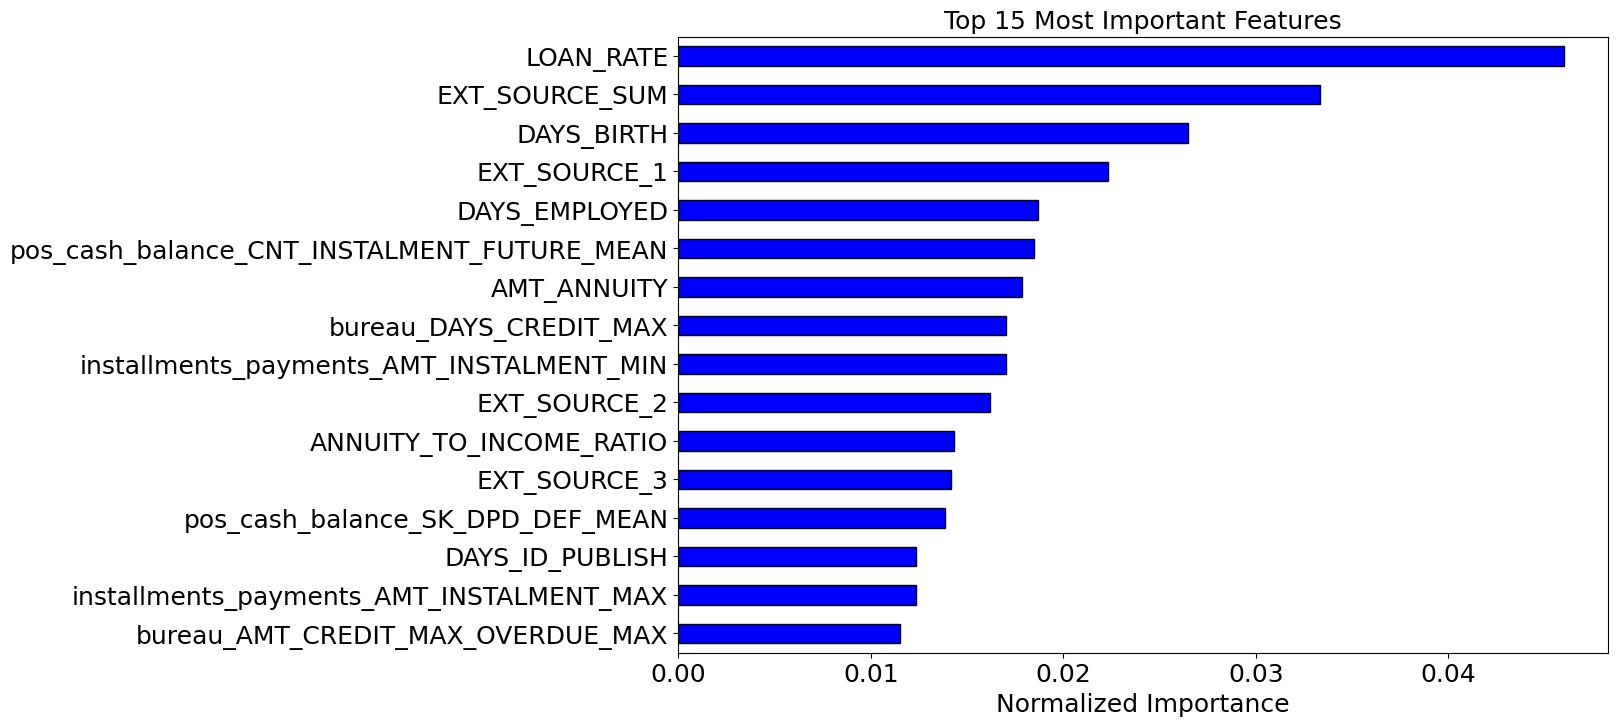

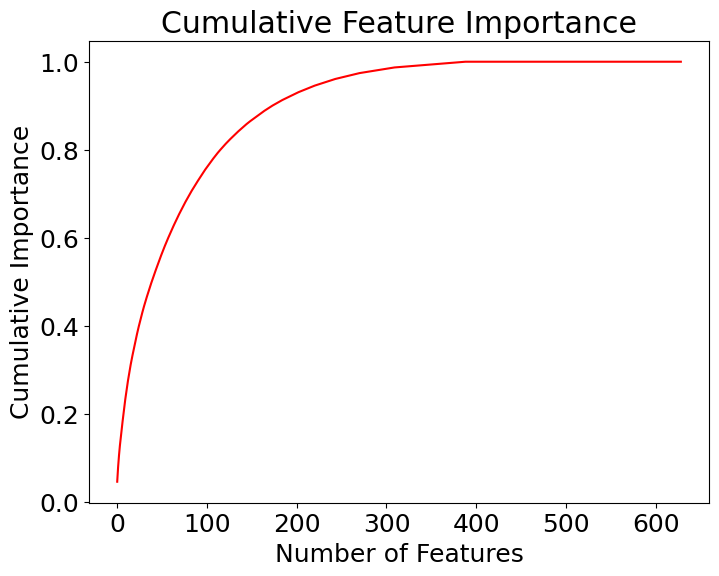

174 features required for 0.90 of cumulative importance


,index,feature,importance,importance_normalized,cumulative_importance
0,74,LOAN_RATE,138.0,0.046000,0.046000
1,76,EXT_SOURCE_SUM,100.0,0.033333,0.079333
2,8,DAYS_BIRTH,79.5,0.026500,0.105833
3,28,EXT_SOURCE_1,67.0,0.022333,0.128167
4,9,DAYS_EMPLOYED,56.0,0.018667,0.146833
5,217,pos_cash_balance_CNT_INSTALMENT_FUTURE_MEAN,55.5,0.018500,0.165333
6,6,AMT_ANNUITY,53.5,0.017833,0.183167
7,533,bureau_DAYS_CREDIT_MAX,51.0,0.017000,0.200167
8,231,installments_payments_AMT_INSTALMENT_MIN,51.0,0.017000,0.217167
9,29,EXT_SOURCE_2,48.5,0.016167,0.233333


In [34]:
norm_feature_importances = plot_feature_importances(feature_importances, n=15) 
norm_feature_importances.head(15)

In [35]:
X_train=X_train.drop(columns = zero_features)
X_test=X_test.drop(columns = zero_features)

In [36]:
gc.enable()
del X_fe,cat_fe,num_fe,sc,feature_importances,model_for_fi,train_features, valid_features, train_target, valid_target,zero_features,norm_feature_importances,
gc.collect()

4280

## Model 

In [38]:
base_models=['Logistic Regression','Random Forest Classifier','Gradient Boosting Classifier','Xgboost Classifier','Naive Bayes Classifier','LGBM Classifier','CatBoost Classifier']
f1_train=[]
auc_train=[]
f1_test=[]
auc_test=[]

## Evaluation Matrix

When working with an imbalanced dataset where all classes are equally important, the macro average F1 score is a good choice because it treats all classes equally. However, if the dataset is imbalanced and you want to give greater weight to classes with more examples, the weighted average F1 score is more appropriate.

In our business case, the goal is to evaluate how capable each applicant is of repaying a loan. To achieve this, we predict the probabilities of loan default using the model's `predict_proba` method. This method returns an \( m \times 2 \) array, where \( m \) is the number of observations. The first column represents the probability of the target being 0 (loan repaid), and the second column represents the probability of the target being 1 (loan not repaid). For our analysis, we are interested in the second column, which gives the probability of a loan default. These probabilities range from 0 to 1, indicating the likelihood of default. If we were to classify applicants, we could define a probability threshold to determine whether a loan is risky, which we will address later.

While I calculate the F1 score for both classes using the macro average to showcase performance (treating both classes equally important), my primary focus is on the ROC AUC score for the positive class (minority class, target = 1, representing loan defaults). The F1 score is mainly for display purposes, but the ROC AUC score for the positive class will serve as the key metric moving forward.ard.

## Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression
LR=LogisticRegression()
LR.fit(X_train,y_train)
ytrain_pred=LR.predict(X_train)
ytrain_proba=LR.predict_proba(X_train)[:, 1]
ytest_pred=LR.predict(X_test)
ytest_proba=LR.predict_proba(X_test)[:, 1]

## Evaluation


In [44]:
print("f1_score of train data considering both Classes: ", f1_score(y_train,ytrain_pred,average='macro'))
print("ROC AUC of train data for Positive Class: ", roc_auc_score(y_train,ytrain_proba))
print("f1_score of test data considering both Classes: ", f1_score(y_test,ytest_pred,average='macro'))
print("ROC AUC of test data for Positive Class: ", roc_auc_score(y_test,ytest_proba))

f1_score of train data considering both Classes:  0.5102393766364975
ROC AUC of train data for Positive Class:  0.7733296060411666
f1_score of test data considering both Classes:  0.5086808522019453
ROC AUC of test data for Positive Class:  0.7674440214539737


In [45]:
f1_train.append(f1_score(y_train,ytrain_pred,average='macro'))
auc_train.append(roc_auc_score(y_train,ytrain_proba))
f1_test.append(f1_score(y_test,ytest_pred,average='macro'))
auc_test.append(roc_auc_score(y_test,ytest_proba))

## Random Forest classsifier

In [47]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
ytrain_pred=rf.predict(X_train)
ytrain_proba=rf.predict_proba(X_train)[:, 1]
ytest_pred=rf.predict(X_test)
ytest_proba=rf.predict_proba(X_test)[:, 1]

## Evaluation

In [49]:
print("f1_score of train data considering both Classes: ", f1_score(y_train,ytrain_pred,average='macro'))
print("ROC AUC of train data for Positive Class: ", roc_auc_score(y_train,ytrain_proba))
print("f1_score of test data considering both Classes: ", f1_score(y_test,ytest_pred,average='macro'))
print("ROC AUC of test data for Positive Class: ", roc_auc_score(y_test,ytest_proba))

f1_score of train data considering both Classes:  0.999835207353321
ROC AUC of train data for Positive Class:  0.9999999999999999
f1_score of test data considering both Classes:  0.48013742375173346
ROC AUC of test data for Positive Class:  0.730460979803453


In [50]:
f1_train.append(f1_score(y_train,ytrain_pred,average='macro'))
auc_train.append(roc_auc_score(y_train,ytrain_proba))
f1_test.append(f1_score(y_test,ytest_pred,average='macro'))
auc_test.append(roc_auc_score(y_test,ytest_proba))

## Gradient Boosting

In [52]:
from sklearn.ensemble import GradientBoostingClassifier
gbc=GradientBoostingClassifier()
gbc.fit(X_train,y_train)
ytrain_pred=gbc.predict(X_train)
ytrain_proba=gbc.predict_proba(X_train)[:, 1]
ytest_pred=gbc.predict(X_test)
ytest_proba=gbc.predict_proba(X_test)[:, 1]


## Evaluation

In [54]:
print("f1_score of train data considering both Classes: ", f1_score(y_train,ytrain_pred,average='macro'))
print("ROC AUC of train data for Positive Class: ", roc_auc_score(y_train,ytrain_proba))
print("f1_score of test data considering both Classes: ", f1_score(y_test,ytest_pred,average='macro'))
print("ROC AUC of test data for Positive Class: ", roc_auc_score(y_test,ytest_proba))

f1_score of train data considering both Classes:  0.4998405831494376
ROC AUC of train data for Positive Class:  0.7767911584429035
f1_score of test data considering both Classes:  0.495270359631119
ROC AUC of test data for Positive Class:  0.7672994365221636


In [55]:
f1_train.append(f1_score(y_train,ytrain_pred,average='macro'))
auc_train.append(roc_auc_score(y_train,ytrain_proba))
f1_test.append(f1_score(y_test,ytest_pred,average='macro'))
auc_test.append(roc_auc_score(y_test,ytest_proba))

## XG Boost Classifier

In [57]:
from xgboost import XGBClassifier
xgc=XGBClassifier()
xgc.fit(X_train,y_train)
ytrain_pred=xgc.predict(X_train)
ytrain_proba=xgc.predict_proba(X_train)[:, 1]
ytest_pred=xgc.predict(X_test)
ytest_proba=xgc.predict_proba(X_test)[:, 1]

## Evaluation

In [59]:
print("f1_score of train data considering both Classes: ", f1_score(y_train,ytrain_pred,average='macro'))
print("ROC AUC of train data for Positive Class: ", roc_auc_score(y_train,ytrain_proba))
print("f1_score of test data considering both Classes: ", f1_score(y_test,ytest_pred,average='macro'))
print("ROC AUC of test data for Positive Class: ", roc_auc_score(y_test,ytest_proba))

f1_score of train data considering both Classes:  0.6044056059309882
ROC AUC of train data for Positive Class:  0.8911925812668218
f1_score of test data considering both Classes:  0.528307222908513
ROC AUC of test data for Positive Class:  0.769385960034056


In [60]:
f1_train.append(f1_score(y_train,ytrain_pred,average='macro'))
auc_train.append(roc_auc_score(y_train,ytrain_proba))
f1_test.append(f1_score(y_test,ytest_pred,average='macro'))
auc_test.append(roc_auc_score(y_test,ytest_proba))

## Naive bayes


In [62]:
from sklearn.naive_bayes import BernoulliNB    
nb=BernoulliNB(alpha=0.01)
nb.fit(X_train,y_train)
ytrain_pred=nb.predict(X_train)
ytrain_proba=nb.predict_proba(X_train)[:, 1]
ytest_pred=nb.predict(X_test)
ytest_proba=nb.predict_proba(X_test)[:, 1]

## Evaluation

In [64]:
print("f1_score of train data considering both Classes: ", f1_score(y_train,ytrain_pred,average='macro'))
print("ROC AUC of train data for Positive Class: ", roc_auc_score(y_train,ytrain_proba))
print("f1_score of test data considering both Classes: ", f1_score(y_test,ytest_pred,average='macro'))
print("ROC AUC of test data for Positive Class: ", roc_auc_score(y_test,ytest_proba))

f1_score of train data considering both Classes:  0.5610844372520685
ROC AUC of train data for Positive Class:  0.711684913744432
f1_score of test data considering both Classes:  0.5623447193509823
ROC AUC of test data for Positive Class:  0.7076055852683474


In [65]:
# Append Model Performace Scores to List
f1_train.append(f1_score(y_train,ytrain_pred,average='macro'))
auc_train.append(roc_auc_score(y_train,ytrain_proba))
f1_test.append(f1_score(y_test,ytest_pred,average='macro'))
auc_test.append(roc_auc_score(y_test,ytest_proba))

## LightGBM Classifier


In [67]:
from lightgbm import LGBMClassifier
lgbm=LGBMClassifier()
lgbm.fit(X_train,y_train)
ytrain_pred=lgbm.predict(X_train)
ytrain_proba=lgbm.predict_proba(X_train)[:, 1]
ytest_pred=lgbm.predict(X_test)
ytest_proba=lgbm.predict_proba(X_test)[:, 1]

[LightGBM] [Info] Number of positive: 19804, number of negative: 226201
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.114221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41087
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 388
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080502 -> initscore=-2.435540
[LightGBM] [Info] Start training from score -2.435540


In [68]:
print("f1_score of train data considering both Classes: ", f1_score(y_train,ytrain_pred,average='macro'))
print("ROC AUC of train data for Positive Class: ", roc_auc_score(y_train,ytrain_proba))
print("f1_score of test data considering both Classes: ", f1_score(y_test,ytest_pred,average='macro'))
print("ROC AUC of test data for Positive Class: ", roc_auc_score(y_test,ytest_proba))

f1_score of train data considering both Classes:  0.5222235650335725
ROC AUC of train data for Positive Class:  0.8283308681344835
f1_score of test data considering both Classes:  0.5086029269725594
ROC AUC of test data for Positive Class:  0.7762290115020217


In [69]:
f1_train.append(f1_score(y_train,ytrain_pred,average='macro'))
auc_train.append(roc_auc_score(y_train,ytrain_proba))
f1_test.append(f1_score(y_test,ytest_pred,average='macro'))
auc_test.append(roc_auc_score(y_test,ytest_proba))

## Cat boost Classifier

In [71]:
from catboost import CatBoostClassifier
cb=CatBoostClassifier()
cb.fit(X_train,y_train)
ytrain_pred=cb.predict(X_train)
ytrain_proba=cb.predict_proba(X_train)[:, 1]
ytest_pred=cb.predict(X_test)
ytest_proba=cb.predict_proba(X_test)[:, 1]

Learning rate set to 0.10811
0:	learn: 0.5905847	total: 227ms	remaining: 3m 46s
1:	learn: 0.5052288	total: 312ms	remaining: 2m 35s
2:	learn: 0.4437005	total: 397ms	remaining: 2m 11s
3:	learn: 0.3996696	total: 483ms	remaining: 2m
4:	learn: 0.3675133	total: 558ms	remaining: 1m 51s
5:	learn: 0.3408442	total: 657ms	remaining: 1m 48s
6:	learn: 0.3216171	total: 745ms	remaining: 1m 45s
7:	learn: 0.3063177	total: 837ms	remaining: 1m 43s
8:	learn: 0.2961836	total: 920ms	remaining: 1m 41s
9:	learn: 0.2870622	total: 1.02s	remaining: 1m 41s
10:	learn: 0.2807235	total: 1.11s	remaining: 1m 40s
11:	learn: 0.2751754	total: 1.22s	remaining: 1m 40s
12:	learn: 0.2703619	total: 1.33s	remaining: 1m 40s
13:	learn: 0.2673815	total: 1.42s	remaining: 1m 39s
14:	learn: 0.2643818	total: 1.52s	remaining: 1m 39s
15:	learn: 0.2619410	total: 1.61s	remaining: 1m 39s
16:	learn: 0.2597321	total: 1.72s	remaining: 1m 39s
17:	learn: 0.2580903	total: 1.81s	remaining: 1m 38s
18:	learn: 0.2565315	total: 1.92s	remaining: 1m 3

## Evaluation

In [73]:
print("f1_score of train data considering both Classes: ", f1_score(y_train,ytrain_pred,average='macro'))
print("ROC AUC of train data for Positive Class: ", roc_auc_score(y_train,ytrain_proba))
print("f1_score of test data considering both Classes: ", f1_score(y_test,ytest_pred,average='macro'))
print("ROC AUC of test data for Positive Class: ", roc_auc_score(y_test,ytest_proba))

f1_score of train data considering both Classes:  0.5966750178097217
ROC AUC of train data for Positive Class:  0.8595381435027474
f1_score of test data considering both Classes:  0.5211817517715963
ROC AUC of test data for Positive Class:  0.7807602503013662


In [74]:
f1_train.append(f1_score(y_train,ytrain_pred,average='macro'))
auc_train.append(roc_auc_score(y_train,ytrain_proba))
f1_test.append(f1_score(y_test,ytest_pred,average='macro'))
auc_test.append(roc_auc_score(y_test,ytest_proba))

## Model Performance parameters

In [157]:
f1_train = f1_train[:len(base_models)]
auc_train = auc_train[:len(base_models)]
f1_test = f1_test[:len(base_models)]
auc_test = auc_test[:len(base_models)]

In [158]:
performace = pd.DataFrame(base_models, columns=['Classifiers'])
performace['f1_score_TrainData'] = f1_train
performace['AUC_TrainData'] = auc_train
performace['f1_score_TestData'] = f1_test
performace['AUC_TestData'] = auc_test
performace

,Classifiers,f1_score_TrainData,AUC_TrainData,f1_score_TestData,AUC_TestData
0,Logistic Regression,0.510239,0.773330,0.508681,0.767444
1,Random Forest Classifier,0.999835,1.000000,0.480137,0.730461
2,Gradient Boosting Classifier,0.499841,0.776791,0.495270,0.767299
3,Xgboost Classifier,0.604406,0.891193,0.528307,0.769386
4,Naive Bayes Classifier,0.561084,0.711685,0.562345,0.707606
5,LGBM Classifier,0.522224,0.828331,0.508603,0.776229
6,CatBoost Classifier,0.596675,0.859538,0.521182,0.780760


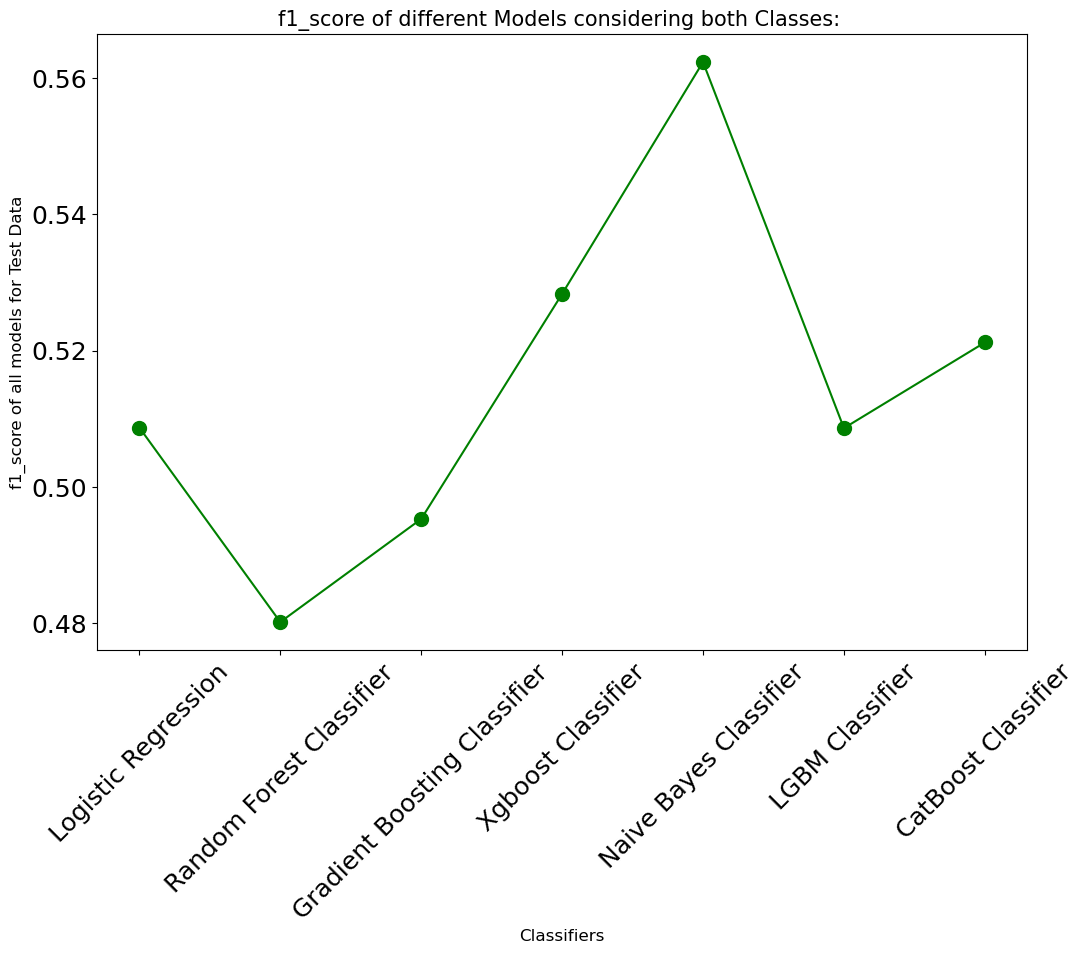

----------------------------------------------------------------------------------------------------


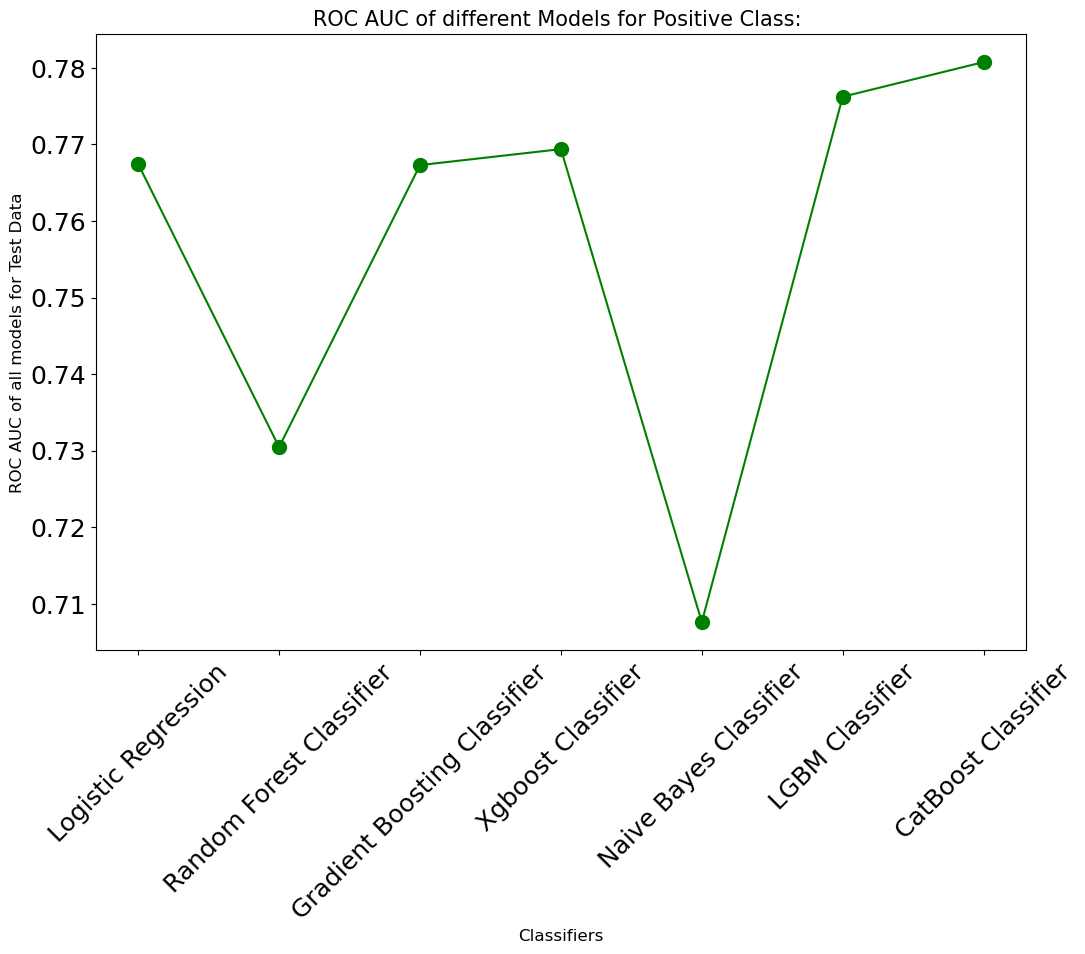

In [159]:
plt.figure(figsize = (12,8))
plt.plot(performace['Classifiers'],performace['f1_score_TestData'],"go-",markersize=10)
plt.xlabel('Classifiers', fontsize = 12)
plt.ylabel('f1_score of all models for Test Data', fontsize = 12)
plt.xticks(rotation=45)
plt.title('f1_score of different Models considering both Classes: ',fontsize = 15)
plt.show()
print('-'*100)
#Plot AUC scores
plt.figure(figsize = (12,8))
plt.plot(performace['Classifiers'],performace['AUC_TestData'],"go-",markersize=10)
plt.xlabel('Classifiers', fontsize = 12)
plt.ylabel('ROC AUC of all models for Test Data', fontsize = 12)
plt.xticks(rotation=45)
plt.title('ROC AUC of different Models for Positive Class: ',fontsize = 15)
plt.show()


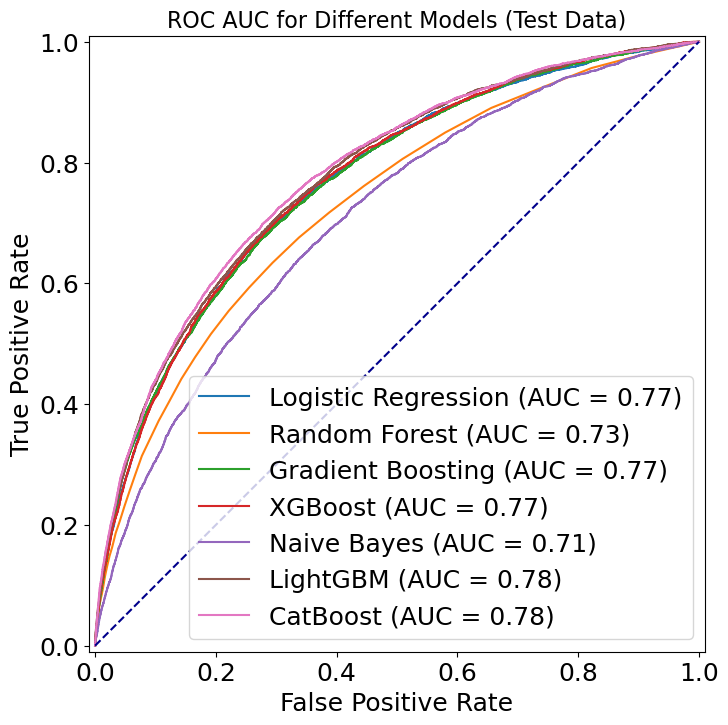

In [197]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot ROC curves for all models
RocCurveDisplay.from_estimator(LR, X_test, y_test, ax=ax, name="Logistic Regression")
RocCurveDisplay.from_estimator(rf, X_test, y_test, ax=ax, name="Random Forest")
RocCurveDisplay.from_estimator(gbc, X_test, y_test, ax=ax, name="Gradient Boosting")
RocCurveDisplay.from_estimator(xgc, X_test, y_test, ax=ax, name="XGBoost")
RocCurveDisplay.from_estimator(nb, X_test, y_test, ax=ax, name="Naive Bayes")
RocCurveDisplay.from_estimator(lgbm, X_test, y_test, ax=ax, name="LightGBM")
RocCurveDisplay.from_estimator(cb, X_test, y_test, ax=ax, name="CatBoost")

# Plot the diagonal line
ax.plot([0, 1], [0, 1], color='darkblue', linestyle='--')

# Add title and labels
ax.set_title('ROC AUC for Different Models (Test Data)', fontsize=16)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

# Show the plot
plt.legend(loc="lower right")
plt.show()



1.These ROC AUC values are for test data.
2.
We can see that our best base line models are LightGBM Classifier and Catboost
 Classifier.
3.
Let us hyper tune them and check results again.`

## Hypertuned Model

In [200]:
tuned_models=['CatBoost','LightGBM']
hmf1_train=[]
hmauc_train=[]
hmf1_test=[]
hmauc_test=[]

## Catboost

Here what I will do is manually iterate some of the parameters. I keep 1 parameter constant and iterate with others and same process continues with rest of the parameters as well. One reason why I am doing this and not using GridSearchCV or RandomSearchCV or any other optimization technique is because it is taking a lot of time to train the model. Some of the features i have tuned are given below. This was done through many differnt trails.

In [204]:
cb_model = CatBoostClassifier(iterations=2000,
                              learning_rate=0.005,
                              depth=7,
                              l2_leaf_reg=40,
                              bootstrap_type='Bernoulli',
                              loss_function='Logloss',
                              subsample=0.8,
                              scale_pos_weight=11,
                              eval_metric='AUC',
                              od_type='Iter',
                              od_wait=50,
                              random_seed=42)


cb_model.fit(X_train, y_train)             
ytrain_pred=cb_model.predict(X_train)
ytrain_proba=cb_model.predict_proba(X_train)[:, 1]
ytest_pred=cb_model.predict(X_test)
ytest_proba=cb_model.predict_proba(X_test)[:, 1]

0:	total: 118ms	remaining: 3m 55s
1:	total: 222ms	remaining: 3m 41s
2:	total: 330ms	remaining: 3m 39s
3:	total: 446ms	remaining: 3m 42s
4:	total: 553ms	remaining: 3m 40s
5:	total: 672ms	remaining: 3m 43s
6:	total: 800ms	remaining: 3m 47s
7:	total: 908ms	remaining: 3m 46s
8:	total: 1.03s	remaining: 3m 47s
9:	total: 1.15s	remaining: 3m 48s
10:	total: 1.27s	remaining: 3m 50s
11:	total: 1.39s	remaining: 3m 50s
12:	total: 1.5s	remaining: 3m 49s
13:	total: 1.62s	remaining: 3m 49s
14:	total: 1.73s	remaining: 3m 49s
15:	total: 1.86s	remaining: 3m 50s
16:	total: 1.99s	remaining: 3m 51s
17:	total: 2.11s	remaining: 3m 52s
18:	total: 2.23s	remaining: 3m 52s
19:	total: 2.36s	remaining: 3m 53s
20:	total: 2.48s	remaining: 3m 53s
21:	total: 2.59s	remaining: 3m 52s
22:	total: 2.72s	remaining: 3m 53s
23:	total: 2.83s	remaining: 3m 52s
24:	total: 2.95s	remaining: 3m 52s
25:	total: 3.08s	remaining: 3m 53s
26:	total: 3.2s	remaining: 3m 53s
27:	total: 3.31s	remaining: 3m 53s
28:	total: 3.42s	remaining: 3m 5

## Evaluation

In [206]:
print("f1_score of train data considering both Classes: ", f1_score(y_train,ytrain_pred,average='macro'))
print("ROC AUC of train data for Positive Class: ", roc_auc_score(y_train,ytrain_proba))
print("f1_score of test data considering both Classes: ", f1_score(y_test,ytest_pred,average='macro'))
print("ROC AUC of test data for Positive Class: ", roc_auc_score(y_test,ytest_proba))

f1_score of train data considering both Classes:  0.5568840503114081
ROC AUC of train data for Positive Class:  0.7875869530746991
f1_score of test data considering both Classes:  0.5533655295369468
ROC AUC of test data for Positive Class:  0.7709864809897543


In [208]:
hmf1_train.append(f1_score(y_train,ytrain_pred,average='macro'))
hmauc_train.append(roc_auc_score(y_train,ytrain_proba))
hmf1_test.append(f1_score(y_test,ytest_pred,average='macro'))
hmauc_test.append(roc_auc_score(y_test,ytest_proba))

## Light GBM

We will optimize the lightGBM using Bayesian Optimization Technique. Bayesian Optimization differs from Random Search and Grid Search in that it improves the search speed using past performances, whereas the other two methods are uniform (or independent) of past evaluations.

In [212]:
def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=5, random_seed=6, n_estimators=10000, learning_rate=0.05): 
    import lightgbm as lgb
    # prepare data
    train_data = lgb.Dataset(data=X, label=y)
    # parameters
    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
        params = {'is_unbalance':True,'application':'binary','num_iterations': n_estimators, 'learning_rate':learning_rate, 'early_stopping_round':100, 'metric':'auc'}
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight 
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
        
    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (20, 50),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (3, 8.99),
                                            'lambda_l1': (0, 5),
                                            'lambda_l2': (0, 3),
                                            'min_split_gain': (0.00001, 0.1),
                                            'min_child_weight': (5, 50)},random_state=0)
        
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    
    # return best parameters
    best_params = max(lgbBO.res, key=lambda x:x['target'])['params']
    return best_params

In [218]:
params={'is_unbalance':True,'application':'binary','learning_rate':0.05,
        'n_estimators':1350, 
        'bagging_fraction': 0.9150613231123395, 
        'feature_fraction': 0.1, 
        'lambda_l1': 2.056984207631514, 
        'lambda_l2': 3.0, 
        'max_depth': 4, 
        'min_child_weight': 46.42561780430163, 
        'min_split_gain': 0.1, 
        'num_leaves': 22}

lgbmh=LGBMClassifier(**params,n_jobs=-1,random_state=6)
lgbmh.fit(X_train,y_train)
ytrain_pred=lgbmh.predict(X_train)
ytrain_proba=lgbmh.predict_proba(X_train)[:, 1]
ytest_pred=lgbmh.predict(X_test)
ytest_proba=lgbmh.predict_proba(X_test)[:, 1]

[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l1 is set=2.056984207631514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.056984207631514
[LightGBM] [Warning] lambda_l2 is set=3.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0
[LightGBM] [Warning] bagging_fraction is set=0.9150613231123395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9150613231123395
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l1 is set=2.056984207631514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.056984207631514
[LightGBM] [Warning] lambda_l2 is set=3.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0
[LightGBM] [Warning] bagging_fraction is set=0.9150613231123395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91506

## Evaluation

In [221]:
print("f1_score of train data considering both Classes: ", f1_score(y_train,ytrain_pred,average='macro'))
print("ROC AUC of train data for Positive Class: ", roc_auc_score(y_train,ytrain_proba))
print("f1_score of test data considering both Classes: ", f1_score(y_test,ytest_pred,average='macro'))
print("ROC AUC of test data for Positive Class: ", roc_auc_score(y_test,ytest_proba))

f1_score of train data considering both Classes:  0.5983873036547924
ROC AUC of train data for Positive Class:  0.8497176228882564
f1_score of test data considering both Classes:  0.5732853255873652
ROC AUC of test data for Positive Class:  0.7831208779714142


In [223]:
# Append Model Performace Scores to List
hmf1_train.append(f1_score(y_train,ytrain_pred,average='macro'))
hmauc_train.append(roc_auc_score(y_train,ytrain_proba))
hmf1_test.append(f1_score(y_test,ytest_pred,average='macro'))
hmauc_test.append(roc_auc_score(y_test,ytest_proba))

## Hypertuned Model Performance 

In [226]:
hp = pd.DataFrame(tuned_models, columns = ['Classifiers'])
hp['f1_score_TrainData'] = hmf1_train
hp['AUC_TrainData'] = hmauc_train
hp['f1_score_TestData'] = hmf1_test
hp['AUC_TestData'] = hmauc_test
hp

,Classifiers,f1_score_TrainData,AUC_TrainData,f1_score_TestData,AUC_TestData
0,CatBoost,0.556884,0.787587,0.553366,0.770986
1,LightGBM,0.598387,0.849718,0.573285,0.783121


[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l1 is set=2.056984207631514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.056984207631514
[LightGBM] [Warning] lambda_l2 is set=3.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0
[LightGBM] [Warning] bagging_fraction is set=0.9150613231123395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9150613231123395


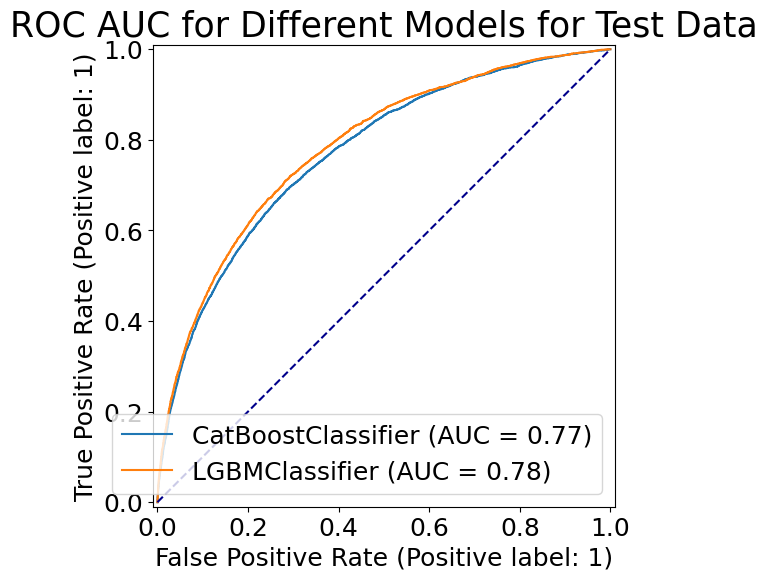

In [230]:
#display ROC AUC of different models:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# Plot ROC curve for cb_model
disp = RocCurveDisplay.from_estimator(cb_model, X_test, y_test)

# Plot ROC curve for lgbmh on the same axes
RocCurveDisplay.from_estimator(lgbmh, X_test, y_test, ax=disp.ax_)

# Add a diagonal reference line
disp.ax_.plot([0, 1], [0, 1], color='darkblue', linestyle='--')

# Add title and labels
disp.ax_.set_title('ROC AUC for Different Models for Test Data', fontsize=25)
plt.show()


From this we can conclude that Hypertuned LightGBM Classifier is the best model for this dataset.

## Feature importance

In [232]:
features = list(X_train.columns)
fi = pd.DataFrame({'feature': features,
                   'importance': lgbmh.feature_importances_}) 

In [234]:
def plot_feature_importances(df, n = 15):
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'blue', edgecolor = 'k', figsize = (12, 8),
                            legend = False)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'Top {n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    
    return df

,index,feature,importance,importance_normalized,cumulative_importance
0,53,LOAN_RATE,583,0.032986,0.032986
1,8,DAYS_BIRTH,292,0.016521,0.049508
2,55,EXT_SOURCE_SUM,283,0.016012,0.065520
3,24,EXT_SOURCE_2,243,0.013749,0.079269
4,25,EXT_SOURCE_3,234,0.013240,0.092509
5,331,bureau_DAYS_CREDIT_MAX,226,0.012787,0.105296
6,6,AMT_ANNUITY,215,0.012165,0.117461
7,23,EXT_SOURCE_1,212,0.011995,0.129456
8,9,DAYS_EMPLOYED,204,0.011542,0.140998
9,134,installments_payments_AMT_INSTALMENT_MIN,199,0.011259,0.152258


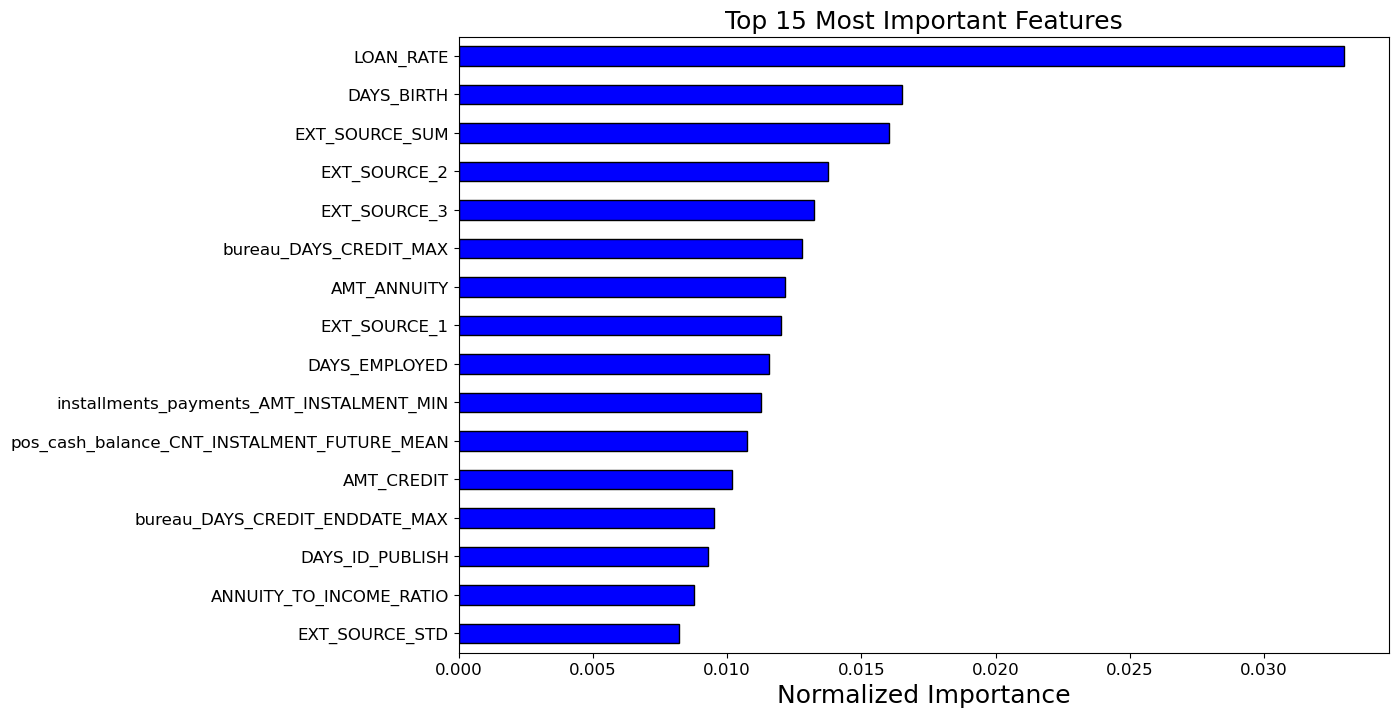

In [236]:
norm_fi = plot_feature_importances(fi, n=15) 
norm_fi.head(15)

## Threshold impact

In [239]:
def predict_threshold (model,X_test,thresholds):     
    return np.where(model.predict_proba(X_test)[:,1]>thresholds,1,0)

In [241]:
# Confusion Matrices for different Thresholds
for thr in np.arange(0,1.0,0.1):
    y_predict = predict_threshold(lgbmh,X_test,thr)   # Considering our best model
    print("Threshold :",thr)
    print(confusion_matrix(y_test,y_predict))

[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l1 is set=2.056984207631514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.056984207631514
[LightGBM] [Warning] lambda_l2 is set=3.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0
[LightGBM] [Warning] bagging_fraction is set=0.9150613231123395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9150613231123395
Threshold : 0.0
[[    0 56481]
 [    0  5021]]
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l1 is set=2.056984207631514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.056984207631514
[LightGBM] [Warning] lambda_l2 is set=3.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0
[LightGBM] [Warning] bagging_fraction is set=0.9150613231123395, subsample=1.0 will be i

Denying a loan to a good customer is less detrimental than approving a loan to a high-risk customer who may default. From a business perspective, minimizing Type 2 errors (false negatives) is more critical in this scenario. This means our primary focus is on reducing false negatives. Lowering the decision threshold can help achieve this, as observed in the confusion matrices—decreasing the threshold reduces false negatives. However, it’s important to strike a balance, as we also want to avoid an excessive number of false positives. A threshold of 0.4 seems reasonable based on the analysis, but we’ll defer the final decision to domain experts and proceed with the default threshold for now..

## Conclusion

Now the question may arise why I chose not to use SMOTE or any undersampling techniques in this project. While I experimented with SMOTE and its variations (SMOTE-Tomek, KMeans SMOTE, and Borderline SMOTE), the results were less effective compared to using the original data. I avoided undersampling because it would result in the loss of valuable information.

One possible reason SMOTE did not yield good results is the low correlation between the features and the target variable. From the EDA, we observed that the feature most correlated with the target variable, `EXT_SOURCE_3`, had a correlation coefficient of only 0.17, which is quite weak. Additionally, SMOTE often struggles with large datasets, where undersampling tends to perform better. However, given the importance of retaining the full dataset, I opted to proceed with the original data points.

From a benchmark perspective, top Kaggle solutions report ROC AUC scores around 0.8–0.81. Considering this, I believe the model's performance is competitive and satisfactory. This marks the completion of the model building and evaluation phase. The project included comprehensive EDA, thorough feature engineering, multiple iterations with various models, and hyperparameter tuning. The model's strong ROC AUC score demonstrates its reliability, making it suitable for real-world applications.